<a href="https://colab.research.google.com/github/abhinavsagar/Breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading & Preprocessing

In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('drive/MyDrive/data/train/benign',128))
malign_train = np.array(Dataset_loader('drive/MyDrive/data/train/malignant',128))
normal_train = np.array(Dataset_loader('drive/MyDrive/data/train/normal',128))
benign_test = np.array(Dataset_loader('drive/MyDrive/data/validation/benign',128))
malign_test = np.array(Dataset_loader('drive/MyDrive/data/validation/malignant',128))
normal_test = np.array(Dataset_loader('drive/MyDrive/data/validation/normal',128))

100%|██████████| 1837/1837 [00:21<00:00, 83.53it/s] 


# Create Label

In [4]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
normal_train_label = np.full(len(normal_train), 2)
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
normal_test_label = np.full(len(normal_test), 2)
# Merge data 
X_train = np.concatenate((benign_train, malign_train, normal_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label, normal_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test, normal_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label, normal_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

# Train and Evalutation split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

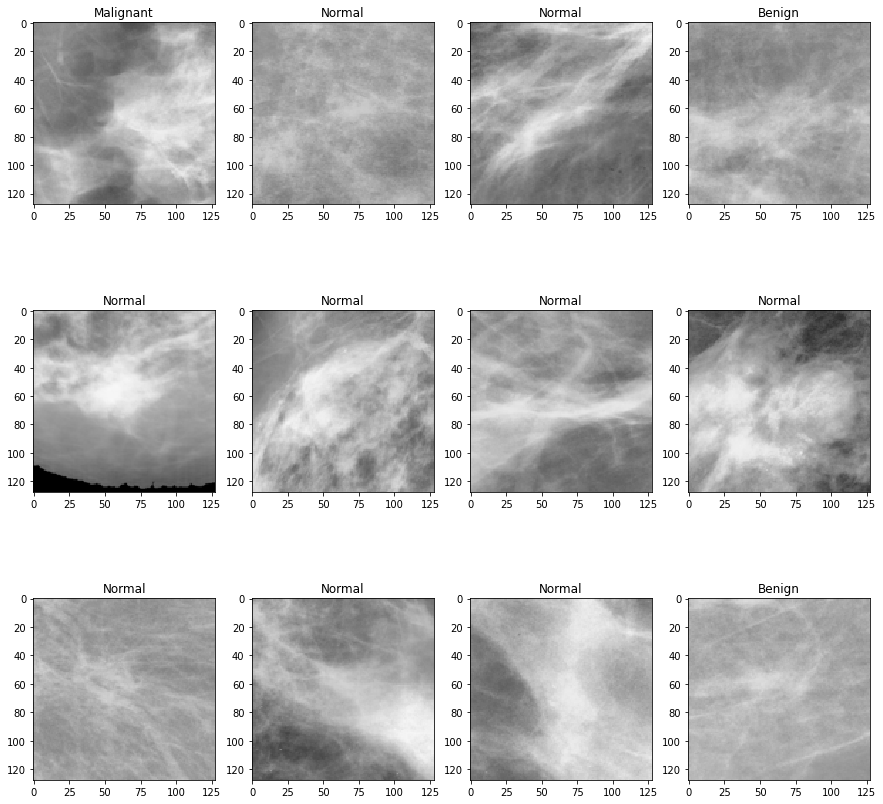

In [6]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Malignant')
    else:
        ax.title.set_text('Normal')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [8]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [9]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(3, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [10]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3)                 5763      
                                                         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [12]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
     steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-12-b1bad24feee2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
449/448 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.6963

448/448 [==============================] - 110s 176ms/step - loss: 0.4862 - accuracy: 0.6963 - val_loss: 0.3111 - val_accuracy: 0.8146 - lr: 1.0000e-04
Epoch 2/20
449/448 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8367

448/448 [==============================] - 66s 148ms/step - loss: 0.2890 - accuracy: 0.8367 - val_loss: 0.2383 - val_accuracy: 0.8602 - lr: 1.0000e-04
Epoch 3/20
449/448 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.8421

448/448 [==============================] - 74s 164ms/step - loss: 0.2728 - accuracy: 0.8421 - val_loss: 0.2337 - val_accuracy: 0.8664 - lr: 1.0000e-04
Epoch 4/20
449/448 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8507

448/448 [==============================] - 66s 148ms/step - loss: 0.2609 - accuracy: 0.8507 - val_loss: 0.2754 - val_accuracy: 0.8452 - lr: 1.0000e-04
Epoch 5/20
449/448 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.8510

448/448 [==============================] - 74s 164ms/step - loss: 0.2572 - accuracy: 0.8510 - val_loss: 0.2185 - val_accuracy: 0.8697 - lr: 1.0000e-04
Epoch 6/20
449/448 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.8534

448/448 [==============================] - 68s 152ms/step - loss: 0.2471 - accuracy: 0.8534 - val_loss: 0.3062 - val_accuracy: 0.8530 - lr: 1.0000e-04
Epoch 7/20
449/448 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.8555

448/448 [==============================] - 69s 153ms/step - loss: 0.2487 - accuracy: 0.8555 - val_loss: 0.3198 - val_accuracy: 0.8168 - lr: 1.0000e-04
Epoch 8/20
449/448 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.8560

448/448 [==============================] - 66s 146ms/step - loss: 0.2429 - accuracy: 0.8560 - val_loss: 0.3066 - val_accuracy: 0.8569 - lr: 1.0000e-04
Epoch 9/20
449/448 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.8546

448/448 [==============================] - 71s 158ms/step - loss: 0.2464 - accuracy: 0.8546 - val_loss: 0.2664 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 10/20
449/448 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.8580

448/448 [==============================] - 66s 146ms/step - loss: 0.2356 - accuracy: 0.8580 - val_loss: 0.3245 - val_accuracy: 0.8157 - lr: 1.0000e-04
Epoch 11/20
449/448 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.8603

448/448 [==============================] - 68s 151ms/step - loss: 0.2344 - accuracy: 0.8603 - val_loss: 0.3134 - val_accuracy: 0.8257 - lr: 1.0000e-04
Epoch 12/20
449/448 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.8648

448/448 [==============================] - 69s 154ms/step - loss: 0.2287 - accuracy: 0.8648 - val_loss: 0.4286 - val_accuracy: 0.7066 - lr: 1.0000e-04
Epoch 13/20
449/448 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.8659

448/448 [==============================] - 66s 147ms/step - loss: 0.2263 - accuracy: 0.8659 - val_loss: 0.2584 - val_accuracy: 0.8474 - lr: 1.0000e-04
Epoch 14/20
449/448 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.8676

448/448 [==============================] - 67s 149ms/step - loss: 0.2309 - accuracy: 0.8676 - val_loss: 0.1912 - val_accuracy: 0.8859 - lr: 1.0000e-04
Epoch 15/20
449/448 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.8624

448/448 [==============================] - 69s 154ms/step - loss: 0.2284 - accuracy: 0.8624 - val_loss: 0.1815 - val_accuracy: 0.8903 - lr: 1.0000e-04
Epoch 16/20
449/448 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.8647

448/448 [==============================] - 67s 150ms/step - loss: 0.2219 - accuracy: 0.8647 - val_loss: 0.2442 - val_accuracy: 0.8591 - lr: 1.0000e-04
Epoch 17/20
449/448 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.8676

448/448 [==============================] - 67s 150ms/step - loss: 0.2254 - accuracy: 0.8676 - val_loss: 0.3267 - val_accuracy: 0.7834 - lr: 1.0000e-04
Epoch 18/20
449/448 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.8713

448/448 [==============================] - 70s 155ms/step - loss: 0.2215 - accuracy: 0.8713 - val_loss: 0.2621 - val_accuracy: 0.8530 - lr: 1.0000e-04
Epoch 19/20
449/448 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.8668

448/448 [==============================] - 68s 151ms/step - loss: 0.2184 - accuracy: 0.8668 - val_loss: 0.2321 - val_accuracy: 0.8591 - lr: 1.0000e-04
Epoch 20/20
449/448 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.8698

448/448 [==============================] - 66s 146ms/step - loss: 0.2149 - accuracy: 0.8698 - val_loss: 0.5374 - val_accuracy: 0.6275 - lr: 1.0000e-04


In [13]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)


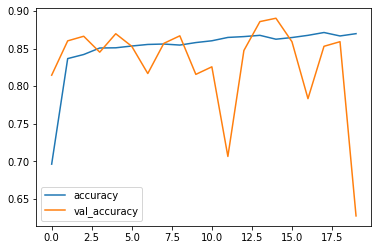

In [15]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

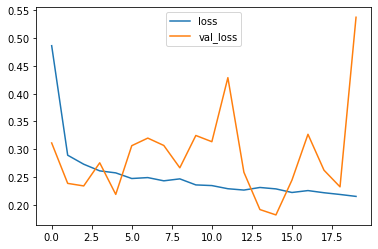

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [18]:
model.save("content/drive/MyDrive/data/my_model.h5")

In [21]:
img = cv2.imread('/content/drive/MyDrive/data/train/benign/9225.png')
resize=cv2.resize(img, dsize = (128,128))
prediction = model.predict(np.expand_dims(resize, 0))
print(prediction)

1/1 [==============================] - 0s 37ms/step
[[0.9502268  0.04808664 0.00168659]]


In [22]:
img = cv2.imread('/content/drive/MyDrive/data/train/malignant/10115.png')
resize=cv2.resize(img, dsize = (128,128))
prediction = model.predict(np.expand_dims(resize, 0))
print(prediction)

1/1 [==============================] - 0s 56ms/step
[[0.20772953 0.78239614 0.00987426]]


In [23]:
img = cv2.imread('/content/drive/MyDrive/data/train/normal/1009.png')
resize=cv2.resize(img, dsize = (128,128))
prediction = model.predict(np.expand_dims(resize, 0))
print(prediction)

1/1 [==============================] - 0s 130ms/step
[[0.00589413 0.01152662 0.98257923]]


In [24]:
Y_val_pred = model.predict(x_val)

57/57 [==============================] - 3s 58ms/step


In [25]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.6275055679287305

In [26]:
Y_pred = model.predict(X_test)

70/70 [==============================] - 6s 87ms/step


In [27]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-27-6b1627227319>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[129  41   6]
 [ 72 141  10]
 [273 569 995]]


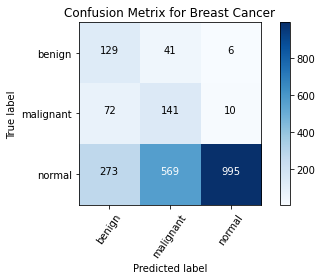

In [28]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant', 'normal']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

Confusion matrix, without normalization
[[ 105   14   57]
 [  66  106   51]
 [  44   54 1739]]


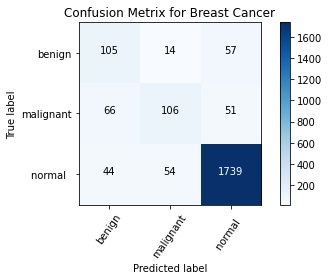

In [29]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant', 'normal  ']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

### Classification Report

In [30]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.49      0.60      0.54       176\n           1       0.61      0.48      0.53       223\n           2       0.94      0.95      0.94      1837\n\n    accuracy                           0.87      2236\n   macro avg       0.68      0.67      0.67      2236\nweighted avg       0.87      0.87      0.87      2236\n'